## Predict TextGrid Events

In [22]:
# KSS Id to run prediction on
kss_id = "1_0007"

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from display import Disp
from audio import Audio
from filename_versioner import FilenameVersioner

font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')

# Display handler with some nice helpers
disp = Disp(display)
# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

In [15]:
import joblib
available_models = [ 'svr_rbf', 'svc_lin', 'svc_rbf']

tng_data_dir = './data/model'
# Here we select the model
fv = FilenameVersioner(('svr_rbf', 'joblib'), base_dir=tng_data_dir )
fv_models = [FilenameVersioner((model, 'joblib'), base_dir=tng_data_dir ) for model in available_models]
fv_shared_params = FilenameVersioner(('shared_params', 'joblib'), base_dir=tng_data_dir)

# print(fv.get_latest_path())
# print(fv_shared_params.get_latest_path())

In [16]:
model_file = fv.get_latest_path()
xy_version, tng_version = fv.get_latest_data()[1].split('.')
model_files = [fv.get_latest_path() for fv in fv_models]
model_versions = [fv.get_latest_data()[1].split('.') for fv in fv_models]

print(xy_version)
print(tng_version)

model = joblib.load(model_file).pipe
models = [joblib.load(model_file) for model_file in model_files]

xy2p1
0


In [17]:
from kss_df import KssDf



kdf_pred = KssDf(kss_id)
shared_params = joblib.load(fv_shared_params.get_latest_path())
audio_params = shared_params['audio']

a_orig = Audio(kdf_pred.audio_path, **audio_params)
X_pred = a_orig.rms.flatten()

print(a_orig.rms.shape)
print(X_pred.shape)

Audio[WARNING]: Modifying input wav from size 154852 to 154880
Audio[INFO]: change in number of samples: 28 [should be less than hop length: 64]
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2421, reduction factor 2420.0


(1, 2421)
(2421,)


## Model Prediction

In [18]:
disp.obj(X_pred.shape, 'X_pred shape')
y_pred = model.predict(X_pred)
disp.obj(y_pred.shape, 'y_pred shape')

y_preds = [(model_name, model.pipe.predict(X_pred)) for model_name, model in zip(available_models, models)]

print(y_preds)

X_pred shape

(2421,)

y_pred shape

(2421,)

[('svr_rbf', array([-0.06841235, -0.06845229, -0.0685418 , ..., -0.03799366,
       -0.03815425, -0.03885619])), ('svc_lin', array([False, False, False, ..., False, False, False])), ('svc_rbf', array([False, False, False, ..., False, False, False]))]


In [19]:
# # A bit of a hack to get the offset.
# # TODO: A better way is to save the AudioPlexer used for training
# calc_offset = np.argmax(x_rms > 0.01) - np.argmax(y_pred > 0.8)
# sw_offset = model['sw'].window - model['sw'].offset
sw_offset = 0

def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')

# # TODO: Move these into a class
def pred_threshold(pred_vals, thresh=0.5):
    return np.where(pred_vals > thresh, True, False)


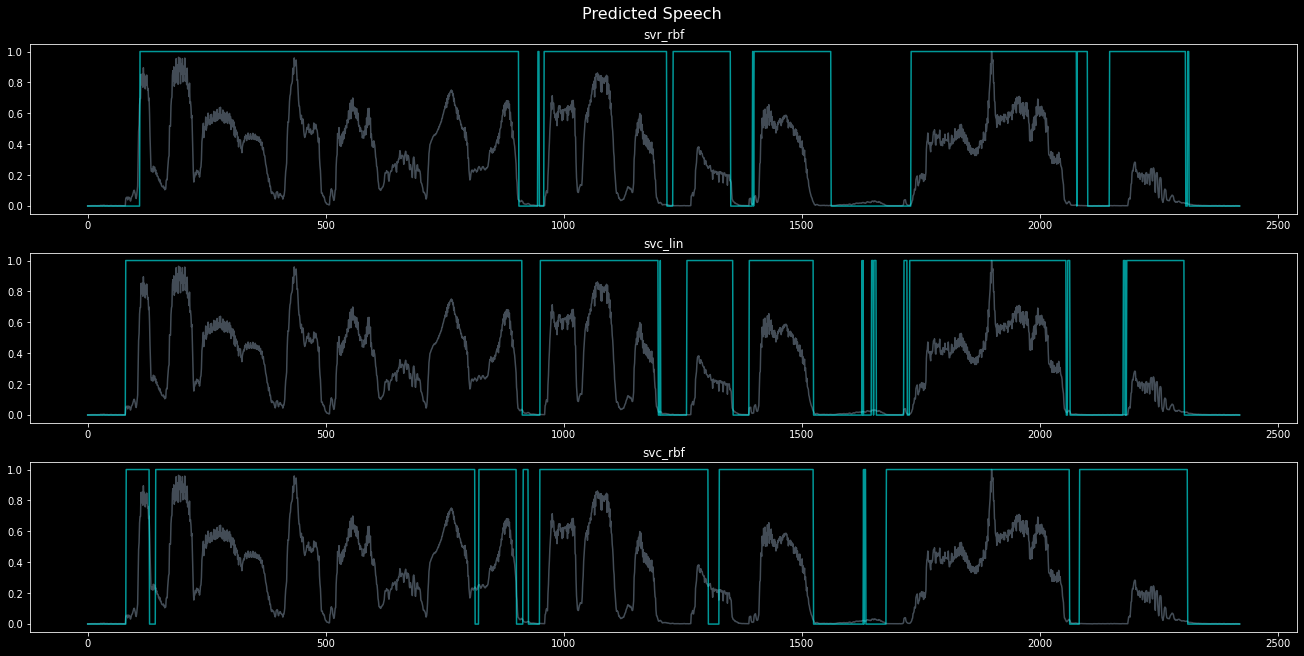

Input Audio

In [20]:
manual_offset1 = 0
manual_offset2 = 64

n_plts = len(y_preds)
fig, axs  = plt.subplots(n_plts, 1, figsize=(18,3*n_plts), constrained_layout=True)
fig.suptitle('Predicted Speech', fontsize=16)

for i, (model_name, model_pred) in enumerate(y_preds):
    axs[i].set_title(f'{model_name}')
    axs[i].plot(X_pred, color='slategray', alpha=0.6, label='X rms waveform')
    axs[i].plot(pred_threshold(align(model_pred, manual_offset1)), color='cyan', alpha=0.6, label='speech prediction')

plt.show()

disp.audio(data=a_orig.wav, rate=a_orig.sr, label='Input Audio')

Testing for Vals

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True])

Event Indices

array([ 110,  906,  946,  949,  959, 1217, 1230, 1351, 1397, 1399, 1400,
       1562, 1730, 2078, 2079, 2101, 2147, 2307, 2311, 2314])

Event Vaues

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True])

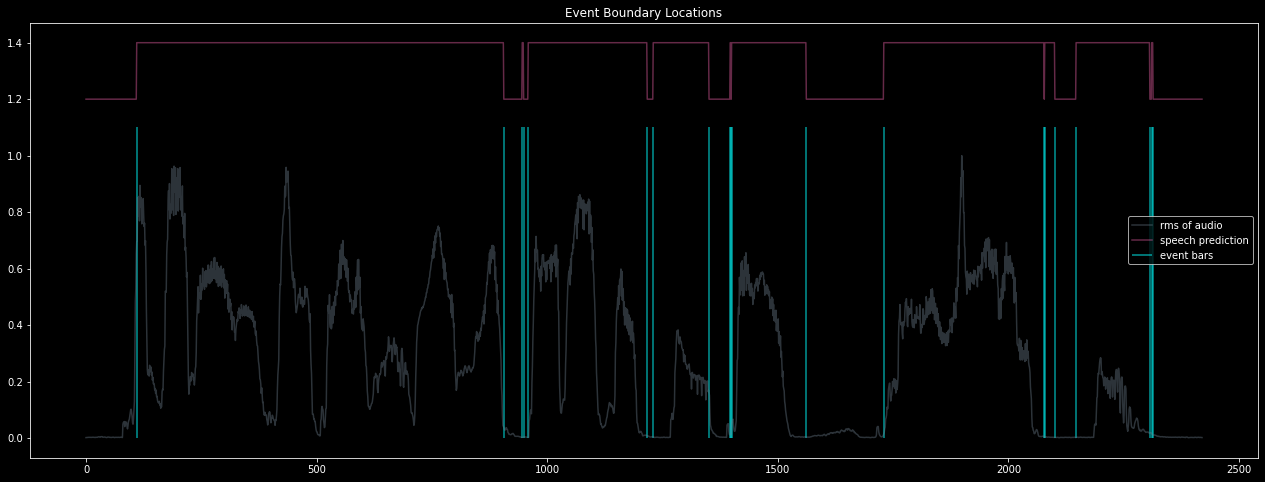

Speech Event_t

array([0.        , 0.15963719, 1.31482993, 1.37287982, 1.37723356,
       1.39174603, 1.7661678 , 1.78503401, 1.96063492, 2.02739229,
       2.03029478, 2.03174603, 2.26684807, 2.5106576 , 3.01569161,
       3.01714286, 3.04907029, 3.11582766, 3.34802721, 3.3538322 ,
       3.35818594])

In [21]:

#TODO: Figure out where to do final alignment
# y_train_pred_bool_align = align(y_train_pred_bool, sw_offset)
y_pred_bool = pred_threshold(y_pred, 0.5)
y_pred_bool_align = align(y_pred_bool, sw_offset)

# TODO: Move these to a class
def get_intervals(bs_in):
    bs = np.pad(bs_in, (1,1), 'edge')
    d = np.diff(bs)
    ivl_idxs = np.where(d > 0)[0]
    disp.obj(bs[ivl_idxs], 'Testing for Vals')
    return ivl_idxs, bs[ivl_idxs]

y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool_align)
disp.obj(y_pred_event_idxs, "Event Indices")
disp.obj(y_pred_event_vals, "Event Vaues")


fig, axs_  = plt.subplots(1, 1, figsize=(22,8), squeeze=False)
axs = axs_[:,0]
axs[0].set_title(f'Event Boundary Locations')
axs[0].plot(X_pred, color='slategray', alpha=0.4, label='rms of audio')
axs[0].plot(align(0.2*y_pred_bool+1.2, manual_offset1), color='hotpink', alpha=0.4, label='speech prediction')
axs[0].vlines(y_pred_event_idxs, 0, 1.1, color='cyan', alpha=0.6, label="event bars")
axs[0].legend(loc='center right')
# axs[0].plot(delta(1*y_svr_pred, y_base, sw_offset, 0), color='cyan', alpha=0.5, label='pred bool - base')
plt.show()


y_pred_event_t = y_pred_event_idxs  * (a_orig.hop_length/a_orig.sr)
# add start event at t=0
# TODO: add end event at t=? (maybe ok to just add end padding??)
speech_event_t = np.pad(y_pred_event_t, (1, 0), constant_values=0.0)
disp.obj(speech_event_t, "Speech Event_t")

In [21]:
def align(y, offset):
    return np.pad(y, (offset, 0), 'minimum')
#Prediction into TextGrid
# need kss_id, xy_version, tng_version to save prediction file
# y_pred_vals for event markers to go to textgrid

# # X_val, _ = ap.sliding_window_features(x_rms, y=y_rms)
# X_val, _ = ap.sliding_window_features(x_rms, y=y_rms)
#
# disp.obj(X_val.shape, 'X_val shape')
# y_pred = model.predict(X_val)
#
# # A bit of a hack to get the offset.
# # TODO: A better way is to save the AudioPlexer used for training
# calc_offset = np.argmax(x_rms > 0.01) - np.argmax(y_pred > 0.8)
# sw_offset = 64 # calc_offset


y_pred_bool = pred_threshold(y_pred, 0.5)
y_pred_bool_align = align(y_pred_bool, sw_offset)
y_pred_event_idxs, y_pred_event_vals = get_intervals(y_pred_bool_align)
# tg_pred_path = f'{tg_dir}/{kss_id}.pred.{xy_version}.{tng_version}.TextGrid'
tg_pred_path = kdf_pred.tg_pred_path(xy_version, tng_version)
# TODO: This really needs to be a class as it should only be one per file.
import string
from pathlib import Path

# TODO: Combine vals into src, for tighter coupling
def make_textgrid(src, vals):
    ivl_template = string.Template(Path('./template/interval.template').read_text())
    item_template = string.Template(Path('./template/item.template').read_text())
    item_list_template = string.Template(Path('./template/itemlist.template').read_text())
    textgrid_template = string.Template(Path('./template/textgrid.template').read_text())

    item_lists_a = []
    for (item_idx, (item_name, event_t)) in enumerate(src):
        ivls_a = []
        # we're going to be taking pairs of data, so skip the last iteration
        ivls_size = len(event_t) - 1
        for i in range(ivls_size):
            ivl_dict = {
                'ivl_id': i+1,
                'ivl_xmin': event_t[i],
                'ivl_xmax': event_t[i+1],
                'ivl_text': f'{vals[i]}' if vals is not None else ' '
            }
            ivls_a.append(ivl_template.substitute(ivl_dict))

        ivls = '\n'.join(ivls_a)

        item_dict = {
            'item_name': item_name,
            'item_xmin': min(event_t),
            'item_xmax': max(event_t),
            'item__intervals_size': ivls_size,
            'item__intervals': ivls
        }
        item = item_template.substitute(item_dict)

        item_list_dict = {
            'item_list_id': item_idx+1,
            'item_list__items': item
        }
        item_lists_a.append(item_list_template.substitute(item_list_dict))

    item_lists = '\n'.join(item_lists_a)
    textgrid_dict = {
        'textgrid_xmin': min(event_t),
        'textgrid_xmax': max(event_t),
        'textgrid_size': len(item_lists_a),
        'textgrid__item_list': item_lists
    }
    return textgrid_template.substitute(textgrid_dict)

def save_textgrid(src, vals, tg_pred_path):
    with open(tg_pred_path, 'w') as f:
        print(f'saving textgrid to {tg_pred_path}')
        f.write(make_textgrid(src, vals))

tg_vals = np.where(y_pred_event_vals, ' ', '0')
textgrid_src = [('char', speech_event_t), ('syl', speech_event_t)]
print('Check to see if save is commented or not')
print(make_textgrid(textgrid_src, tg_vals))
save_textgrid(textgrid_src, tg_vals, tg_pred_path)

Testing for Vals

array([False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True])

Check to see if save is commented or not
File type = "ooTextFile"
Object class = "TextGrid"

xmin = 0.0
xmax = 2.6673922902494334
tiers? <exists>
size = 2
item []:
    item [1]:
        class = "IntervalTier"
        name = "char"
        xmin = 0.0
        xmax = 2.6673922902494334
        intervals: size = 14
       intervals [1]:
          xmin = 0.0
          xmax = 0.2525170068027211
          text = "0"
       intervals [2]:
          xmin = 0.2525170068027211
          xmax = 1.400453514739229
          text = " "
       intervals [3]:
          xmin = 1.400453514739229
          xmax = 1.507845804988662
          text = "0"
       intervals [4]:
          xmin = 1.507845804988662
          xmax = 1.512199546485261
          text = " "
       intervals [5]:
          xmin = 1.512199546485261
          xmax = 1.581859410430839
          text = "0"
       intervals [6]:
          xmin = 1.581859410430839
          xmax = 1.583310657596372
          text = " "
       intervals [7]:

In [20]:
# # Validation
# import pandas as pd
# from kss_textgrid import KssTextGrid
# # TODO: Compare Predicted vs Actual TextGrid
#
# tg_dir = 'data/korean-single-speaker/kss/1'
# # tg_file = '1_0003.TextGrid'
# # audio_file = '1_0003.wav'
# # tg_path = f'{tg_dir}/{tg_file}'
# # audio_path = f'{tg_dir}/{audio_file}'
# # print(tg_path)
# # tg = textgrid.TextGrid.fromFile(tg_path)
# val_kss_id = '1_0005'
#
# syls_df_pred = KssTextGrid(val_kss_id, tg_dir, path=tg_pred_path).syls_df()
# disp.obj(syls_df_pred[syls_df_pred['syl'] == '0'], f'Predicted Syl DF for {val_kss_id}')
#
# assert(val_kss_id == kss_id, f'{val_kss_id} != {kss_id}')
#
# syls_df_actual = KssTextGrid(val_kss_id, tg_dir).syls_df()
# disp.obj(syls_df_actual[syls_df_actual['syl'] == '0'], f'Actual Syl DF for {val_kss_id}')